# 3.6.5 Cancer Prediction Challenge

__Challenge from Thinkful Site:__ Using set of breast cancer data, create a model to predict breast cancer. Also, what traits are most indicative of whether or not an individual will be diagnosed?

__Source:__ [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Original%29)

__Relevant Information:__ Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass.  They describe characteristics of the cell nuclei present in the image. A few of the images can be found at http://www.cs.wisc.edu/~street/images/

__Attribute Information:__ 

1) ID number

2) Diagnosis (M = malignant, B = benign)

Ten real-valued features are computed for each cell nucleus:

	a) radius (mean of distances from center to points on the perimeter)
	b) texture (standard deviation of gray-scale values)
	c) perimeter
	d) area
	e) smoothness (local variation in radius lengths)
	f) compactness (perimeter^2 / area - 1.0)
	g) concavity (severity of concave portions of the contour)
	h) concave points (number of concave portions of the contour)
	i) symmetry 
	j) fractal dimension ("coastline approximation" - 1)

The mean, standard error, and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features.  For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.

In [1]:
#necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#cross validation imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

#Model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [2]:
bcd = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', 
                  header=None,
                 names=['ID_number', 'Diagnosis', 
                     'mean_radius','mean_texture', 'mean_perimeter','mean_area','mean_smoothness',
                  'mean_compactness','mean_concavity','mean_concave points','mean_symmetry','mean_fractal_dimension',
                          'se_radius','se_texture', 'se_perimeter','se_area','se_smoothness',
                  'se_compactness','se_concavity','se_concave points','se_symmetry','se_fractal_dimension',
                          'largest_radius','largest_texture', 'largest_perimeter','largest_area','largest_smoothness',
                  'largest_compactness','largest_concavity','largest_concave points','largest_symmetry','largest_fractal_dimension'])

In [3]:
bcd.head()

,ID_number,Diagnosis,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave points,...,largest_radius,largest_texture,largest_perimeter,largest_area,largest_smoothness,largest_compactness,largest_concavity,largest_concave points,largest_symmetry,largest_fractal_dimension
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


For each diagnosis, there are certain attributes of the tumor that is reported as a mean, standard error, and a largest or 'worst' value.

Now let's inspect if there are any missing values in the data.

In [4]:
bcd.isnull().sum()

ID_number                    0
Diagnosis                    0
mean_radius                  0
mean_texture                 0
mean_perimeter               0
mean_area                    0
mean_smoothness              0
mean_compactness             0
mean_concavity               0
mean_concave points          0
mean_symmetry                0
mean_fractal_dimension       0
se_radius                    0
se_texture                   0
se_perimeter                 0
se_area                      0
se_smoothness                0
se_compactness               0
se_concavity                 0
se_concave points            0
se_symmetry                  0
se_fractal_dimension         0
largest_radius               0
largest_texture              0
largest_perimeter            0
largest_area                 0
largest_smoothness           0
largest_compactness          0
largest_concavity            0
largest_concave points       0
largest_symmetry             0
largest_fractal_dimension    0
dtype: i

To begin our analysis, let's analyze the distribution of diagnoses with a countplot.

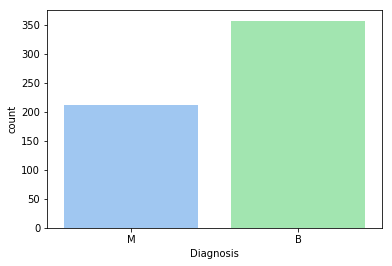

B    357
M    212
Name: Diagnosis, dtype: int64


In [5]:
sns.countplot(x='Diagnosis', data=bcd, palette='pastel')
plt.show()
print(bcd.Diagnosis.value_counts())

This data is not significantly skewed toward one diagnosis or the other.  There are more benign tumor diagnoses than malignant.  This makes sense as tumors start out as benign and become malignent.  We can use the data as-is without imputing.

Great, there are no null or missing values in this data set.  Now let's examine the distribution of each of these values for malignant and benign cancers.

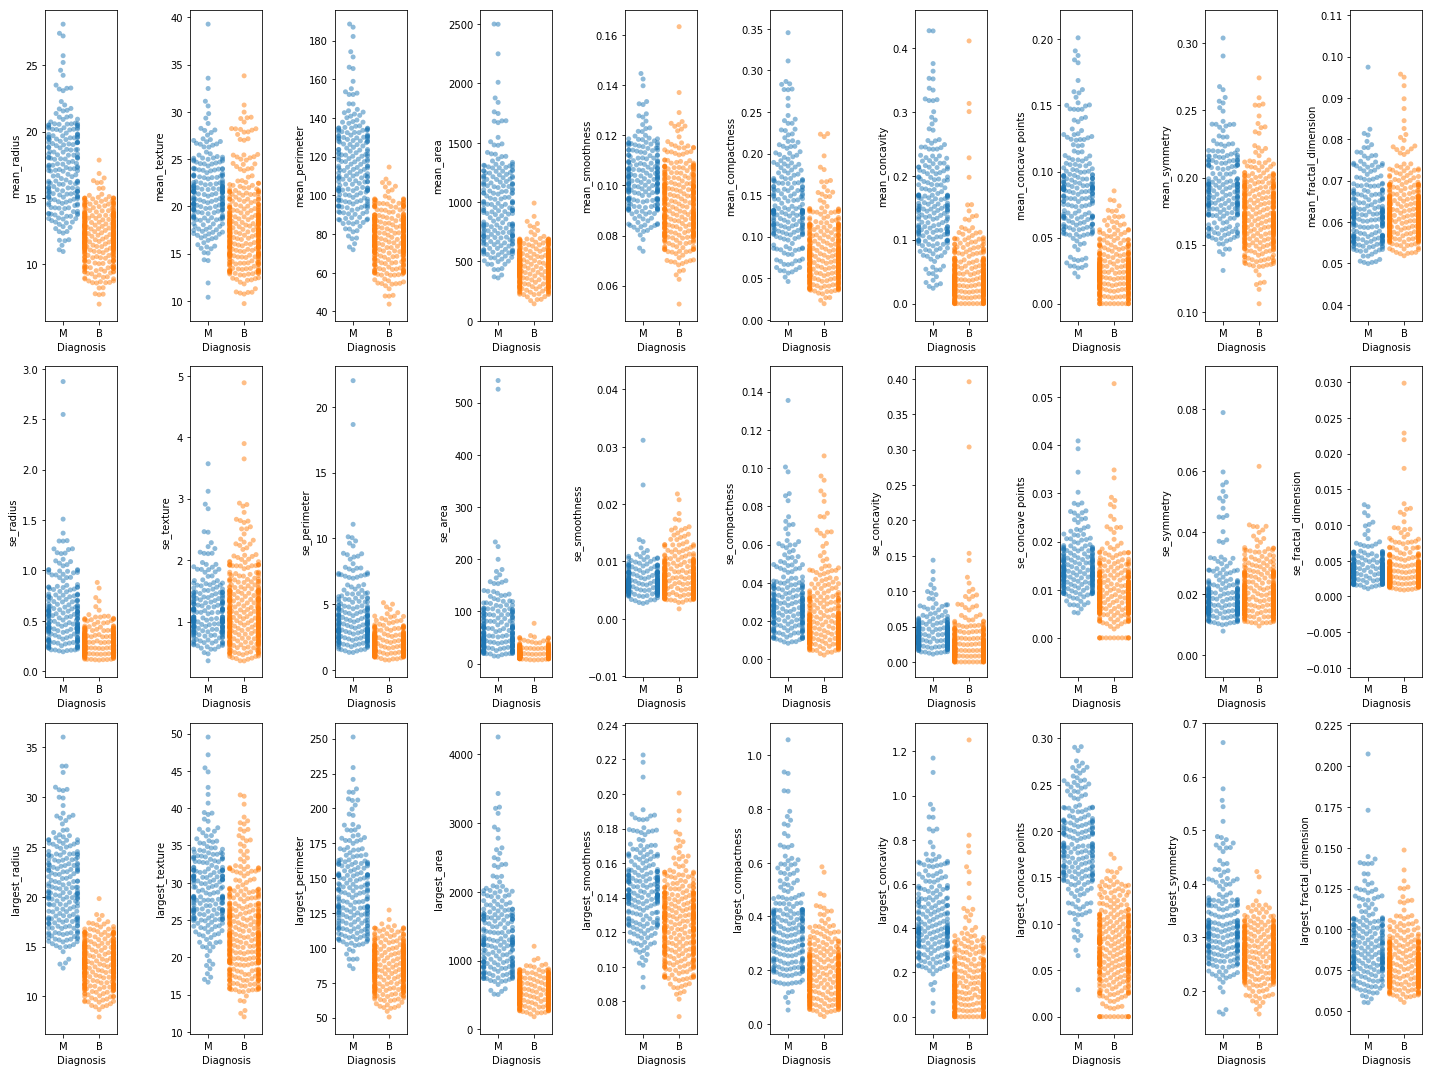

In [6]:
plt.figure(figsize=(20,15))
i=1
p_vals = pd.DataFrame(columns=['Attribute', 'MB_P-value'])
for col in bcd.columns.drop(['Diagnosis', 'ID_number']):
    plt.subplot(3,10,i)
    sns.swarmplot(x='Diagnosis', y=col, data=bcd, alpha=0.5)
    t_val, p_val = ttest_ind(bcd[bcd['Diagnosis']=='M'][col],
                            bcd[bcd['Diagnosis']=='B'][col])
    p_vals = p_vals.append({'Attribute':col, 'MB_P-value':float(p_val)}, 
                                    ignore_index=True)
    i+=1
plt.tight_layout()
plt.show()

Based on this data, it appears that for malignant, all mean values are higher than those for benign tumors with the exception of fractal dimension.  The standard error values are also higher for malignant tumors with the exception of smoothness, symmetry, and fractal dimension.  Finally, the largest values are higher for malignant tumors than benign tumors for all categories.

Next, let's inspect the p-values between benign and malignant tumors to determine which are statistically different from one another.

In [7]:
p_vals.sort_values('MB_P-value', ascending=False)

,Attribute,MB_P-value
18,se_symmetry,8.766418e-01
11,se_texture,8.433320e-01
9,mean_fractal_dimension,7.599368e-01
14,se_smoothness,1.102966e-01
19,se_fractal_dimension,6.307355e-02
16,se_concavity,8.260176e-10
15,se_compactness,9.975995e-13
29,largest_fractal_dimension,2.316432e-15
8,mean_symmetry,5.733384e-16
4,mean_smoothness,1.051850e-18


Based on this data, it appears that most values are statistically different from one another, with the exception of the standard error of symmetry, texture, and smoothness, and the mean fractal dimension. 

## Feature Engineering

I'll use all columns that have significant differences between the benign and malignant tumor types.  I will also create a binary outcome for benign and malignant.

In [8]:
#create features and binary target
features = bcd.drop(['ID_number', 'Diagnosis', 'se_symmetry',
                    'se_texture', 'mean_fractal_dimension',
                    'se_smoothness'], axis=1)
features['Diagnosis'] = bcd.Diagnosis.map(lambda x: 0 if x=='B' else 1)
features.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave points,mean_symmetry,se_radius,...,largest_texture,largest_perimeter,largest_area,largest_smoothness,largest_compactness,largest_concavity,largest_concave points,largest_symmetry,largest_fractal_dimension,Diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,1.0950,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.5435,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.7456,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.4956,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.7572,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


Now that we've created a set of features, let's inspect the correlation between the different features.

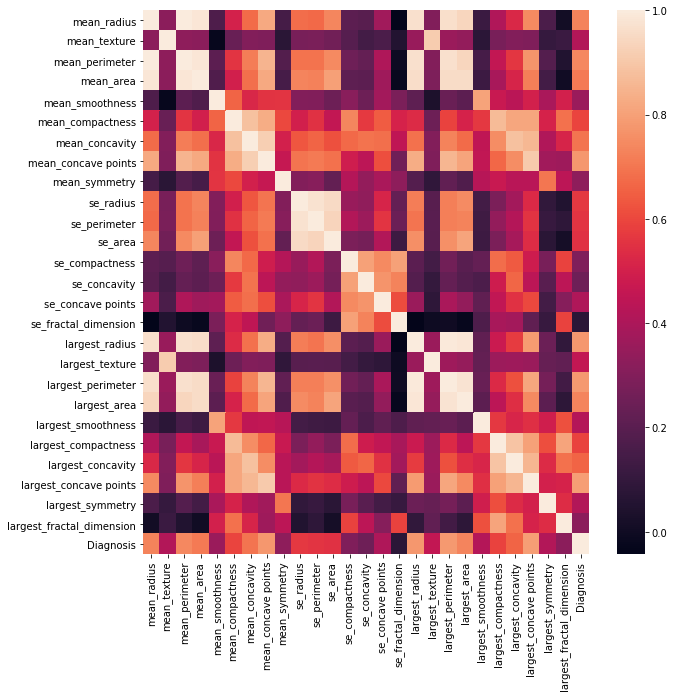

In [9]:
corrmat = features.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat)
plt.show()

As expected, there is a strong correlation between the mean, standard error, and largest values for the tumors. There is also a strong positive correlation between the diagnosis and each feature.  Knowing this, my plan is to start modeling using a Random Forest model and also use logistic regression to predict if a tumor is benign or malignant. 

## Modeling
### Random Forest

In [10]:
#identifying variables
X = features.drop('Diagnosis', axis=1)
y = features['Diagnosis']

#splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

             precision    recall  f1-score   support

     Benign       1.00      1.00      1.00       272
  Malignant       1.00      0.99      1.00       183

avg / total       1.00      1.00      1.00       455



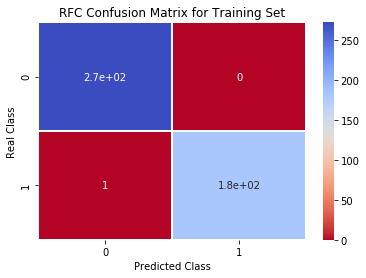

In [11]:
#instantiating and fitting default model
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_train)

#building confusion matrix
conf_matrix_train_rfc = confusion_matrix(y_train, y_pred_rfc)
#printing classification report
print(classification_report(y_train, y_pred_rfc, target_names=['Benign', 'Malignant']))

#creating heatmap of confusion matrix
sns.heatmap(conf_matrix_train_rfc,
           cmap='coolwarm_r',
           annot=True,
           linewidths=0.5)
plt.title('RFC Confusion Matrix for Training Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

From the perfect precision, recall, and f1-scores, it appears that the model is extremely overfit.  I will try to optimize parameters for the random forest first before continuing to the test set.

In [12]:
parameters = {'n_estimators':[10,100,500],
             'max_features':['auto', 'sqrt', 'log2'],
             'min_samples_split':[2,8,20],
             'bootstrap':[True, False]}
grid_rfc = GridSearchCV(rfc, param_grid=parameters, cv=5)
grid_rfc.fit(X_train, y_train)
print(grid_rfc.best_score_)
print(grid_rfc.best_params_)

0.9648351648351648
{'bootstrap': True, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}


Using these best parameters, I will create a new model to predict using the training and test sets

             precision    recall  f1-score   support

     Benign       1.00      1.00      1.00       272
  Malignant       1.00      1.00      1.00       183

avg / total       1.00      1.00      1.00       455



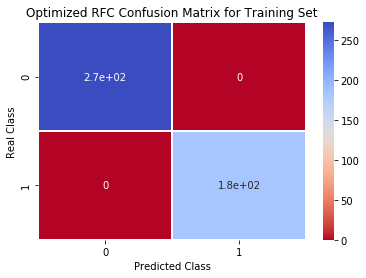

In [13]:
#instantiating model with best parameters
best_params_rfc = grid_rfc.best_params_
rfc2 = RandomForestClassifier(**best_params_rfc)
rfc2.fit(X_train, y_train)
y_pred_rfc2 = rfc2.predict(X_train)
#printing classification report
print(classification_report(y_train, y_pred_rfc2, target_names=['Benign', 'Malignant']))

#building confusion matrix
conf_matrix_train_rfc2 = confusion_matrix(y_train, y_pred_rfc2)
#creating heatmap of confusion matrix
sns.heatmap(conf_matrix_train_rfc2,
           cmap='coolwarm_r',
           annot=True,
           linewidths=0.5)
plt.title('Optimized RFC Confusion Matrix for Training Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

This model is still overfitting.  Let's check out the test set to see how it performs.

             precision    recall  f1-score   support

     Benign       1.00      1.00      1.00        85
  Malignant       1.00      1.00      1.00        29

avg / total       1.00      1.00      1.00       114



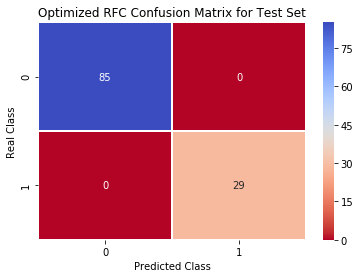

In [14]:
y_pred_rfc2_test = rfc2.predict(X_test)
#printing classification report
print(classification_report(y_test, y_pred_rfc2_test, target_names=['Benign', 'Malignant']))

#building confusion matrix
conf_matrix_train_rfc2_test = confusion_matrix(y_test, y_pred_rfc2_test)
#creating heatmap of confusion matrix
sns.heatmap(conf_matrix_train_rfc2_test,
           cmap='coolwarm_r',
           annot=True,
           linewidths=0.5)
plt.title('Optimized RFC Confusion Matrix for Test Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

Yep, definitely still overfitting. 